<a href="https://colab.research.google.com/github/msinan52/NLP9Hafta/blob/main/1_nlp_lr_nb_rf_xgboots_70_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set_style("white")
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/__1-IEEE_NEWS

Mounted at /content/drive
/content/drive/My Drive/__1-IEEE_NEWS


In [5]:
df = pd.read_csv("sonpre.csv")
df.head()

,Text,Label
0,real number death,0
1,taking dioxide help fight coronavirus,0
2,video show u state florida,0
3,predicted coronavirus outbreak,0
4,chinese president mosque amid coronavirus outb...,0


In [ ]:
df.shape

(7588, 2)

In [ ]:
df.isnull().sum()

Text     0
Label    0
dtype: int64

## Preprocessing and Data Visualization

In [ ]:
df2 = df.copy()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#capitalization conversion
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#punctuation
df['Text'] = df['Text'].str.replace('[^\w\s]','')

#numbers
df['Text'] = df['Text'].str.replace('\d','')
#stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
del_word = pd.Series(' '.join(df['Text']).split()).value_counts()[1500:]
#erasure sparse
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in del_word))
#lemmi
from textblob import Word
#nltk.download('wordnet')
df['Text'] = df['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

#son pre düzgün ve kaydettim


In [ ]:
csv_file_path = '/content/drive/My Drive/__1-IEEE_NEWS/sonpre.csv'

# Export DataFrame to CSV
df.to_csv(csv_file_path, index=False)

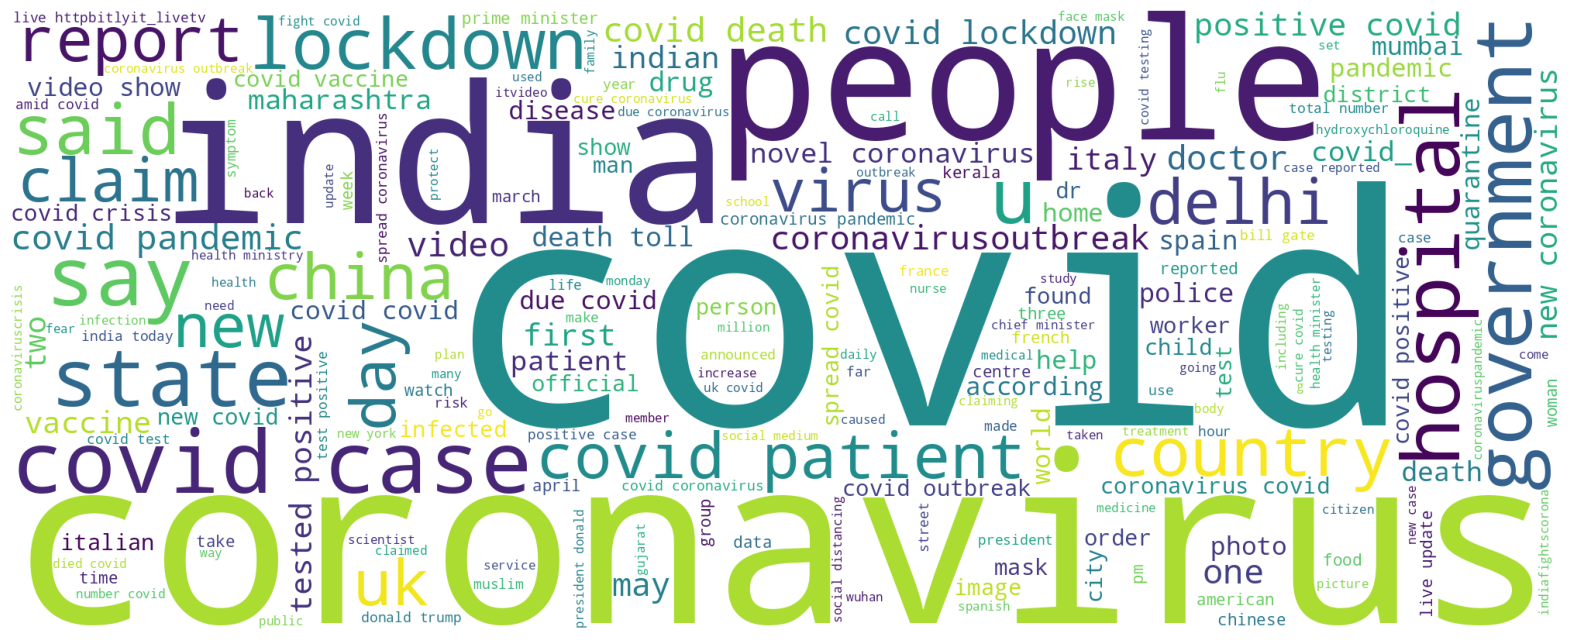

In [ ]:
words  = " ".join(x for x in df.Text)
plt.figure(figsize=(20,10))
wordcloud = WordCloud(background_color="white", width = 2000, height = 800).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Text(0, 0.5, 'Number of samples')

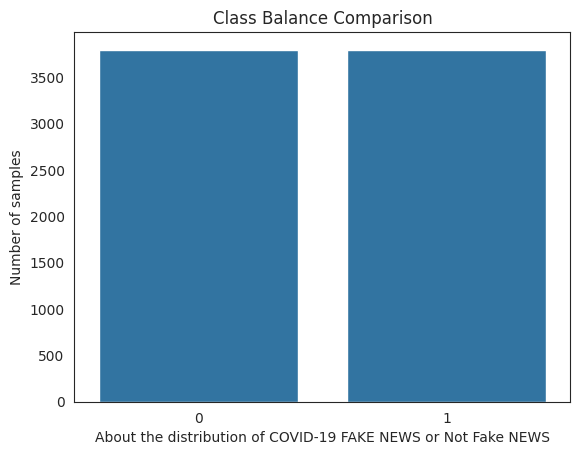

In [ ]:
import seaborn as sns
sns.countplot(x='Label', data=df)
plt.title("Class Balance Comparison")
plt.xlabel("About the distribution of COVID-19 FAKE NEWS or Not Fake NEWS")
plt.ylabel("Number of samples")

Text(0, 0.5, 'Number of samples')

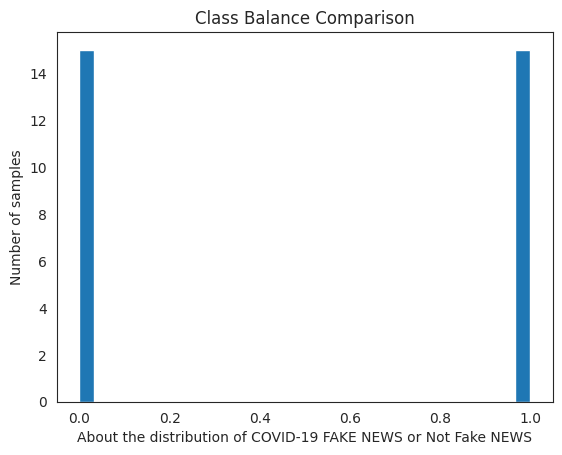

In [ ]:
plt.hist(df["Label"],density=True,bins=30)
plt.title("Class Balance Comparison")
plt.xlabel("About the distribution of COVID-19 FAKE NEWS or Not Fake NEWS")
plt.ylabel("Number of samples")

In [ ]:
df.shape

(7588, 2)

In [ ]:
df.columns

Index(['Text', 'Label'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    7588 non-null   object
 1   Label   7588 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


## Feature Extection--Count vectorizer and TF-IDF

In [6]:
# Train and Test Split
from sklearn import model_selection, preprocessing
x_train, x_test, y_train, y_test = model_selection.train_test_split(df["Text"], df["Label"], random_state=21, test_size=0.30)

In [7]:
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [9]:
# Count
from sklearn.feature_extraction.text import CountVectorizer

# NaN temizleme
x_train = x_train.fillna('')
x_test = x_test.fillna('')

vectorizer = CountVectorizer(max_features=500)
vectorizer.fit(x_train)
x_train_count = vectorizer.transform(x_train)
x_test_count = vectorizer.transform(x_test)


In [10]:
## TF- IDF
from sklearn.feature_extraction.text import  TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer(max_features=500)
tf_idf_vectorizer.fit(x_train)
x_train_tf_idf = tf_idf_vectorizer.transform(x_train)
x_test_tf_idf = tf_idf_vectorizer.transform(x_test)

## Models

In [11]:
models_results = []
model_names = []

# Logistic Regression--BOW

In [28]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
log_reg = linear_model.LogisticRegression()
log_model_bow = log_reg.fit(x_train_count, y_train)
acc = model_selection.cross_val_score(
    log_model_bow,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("Logistic Regression | BOW")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = log_model_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.9108636149126946 



              precision    recall  f1-score   support

           0     0.9347    0.8975    0.9157      1180
           1     0.8942    0.9325    0.9130      1097

    accuracy                         0.9144      2277
   macro avg     0.9145    0.9150    0.9143      2277
weighted avg     0.9152    0.9144    0.9144      2277



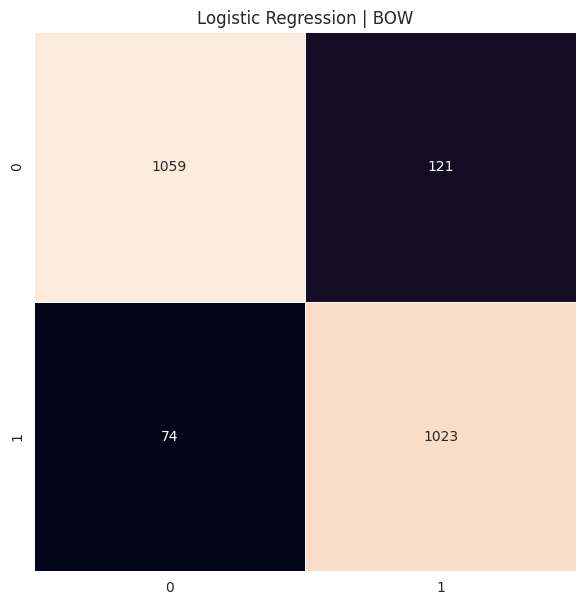

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("Logistic Regression | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# Logistic Regression--TF-IDF

In [29]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
log_reg = linear_model.LogisticRegression()
log_model_tf = log_reg.fit(x_train_tf_idf, y_train)
acc = model_selection.cross_val_score(
    log_model_tf,
    x_test_tf_idf,
    y_test,
    cv=7).mean()

model_names.append("Logistic Regression | TF-IDF")
models_results.append(acc)
print("Accuracy TF-IDF:", acc, "\n\n\n")

y_pred = log_model_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy TF-IDF: 0.8963702555113598 



              precision    recall  f1-score   support

           0     0.9180    0.8915    0.9046      1180
           1     0.8868    0.9143    0.9004      1097

    accuracy                         0.9025      2277
   macro avg     0.9024    0.9029    0.9025      2277
weighted avg     0.9030    0.9025    0.9025      2277



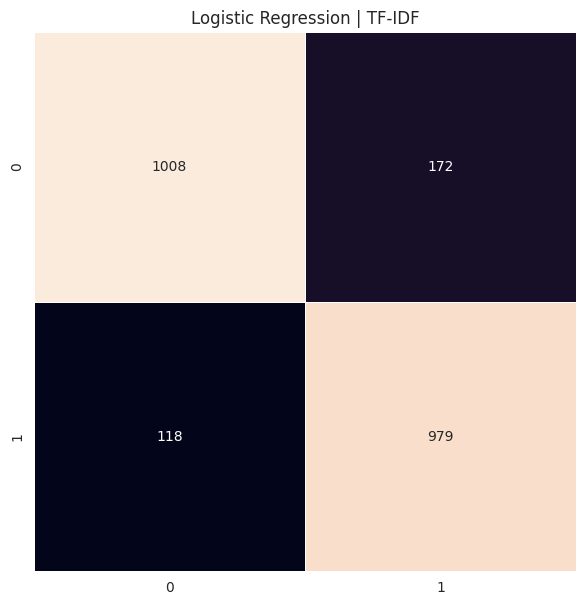

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("Logistic Regression | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# NB--TFIDF

In [30]:
from sklearn import naive_bayes
nb = naive_bayes.MultinomialNB()
nb_model_bow  = nb.fit(x_train_count, y_train)
acc = model_selection.cross_val_score(
        nb_model_bow,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("Naive Bayes | BOW")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = nb_model_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.8722200498887615 



              precision    recall  f1-score   support

           0     0.8952    0.8542    0.8742      1180
           1     0.8506    0.8924    0.8710      1097

    accuracy                         0.8726      2277
   macro avg     0.8729    0.8733    0.8726      2277
weighted avg     0.8737    0.8726    0.8727      2277



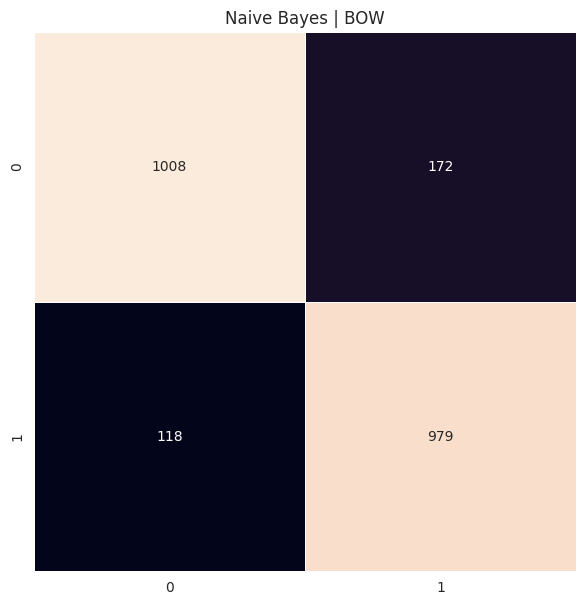

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("Naive Bayes | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# nb tfidf

In [31]:
from sklearn import naive_bayes
nb = naive_bayes.MultinomialNB()
nb_model_tf  = nb.fit(x_train_tf_idf, y_train)
acc = model_selection.cross_val_score(
    nb_model_tf,
    x_test_tf_idf,
    y_test,
    cv=7).mean()

model_names.append("Naive Bayes | TF-IDF")
models_results.append(acc)
print("Accuracy TF-IDF:", acc, "\n\n\n")

y_pred = nb_model_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy TF-IDF: 0.8498119058855255 



              precision    recall  f1-score   support

           0     0.8596    0.8508    0.8552      1180
           1     0.8413    0.8505    0.8459      1097

    accuracy                         0.8507      2277
   macro avg     0.8504    0.8507    0.8505      2277
weighted avg     0.8508    0.8507    0.8507      2277



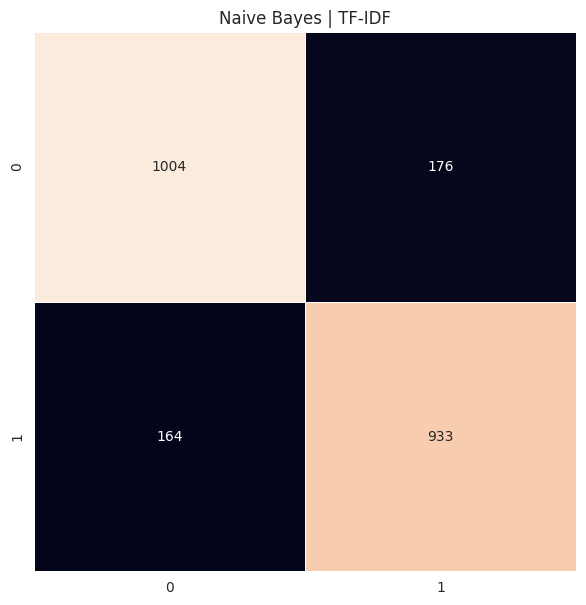

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("Naive Bayes | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# xgb bow

In [32]:
import xgboost
xgb = xgboost.XGBClassifier()
xgb_model_bow = xgb.fit(x_train_count, y_train)
acc = model_selection.cross_val_score(
    xgb_model_bow,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("XGBoost | BOW")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = xgb_model_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.9073484797411178 



              precision    recall  f1-score   support

           0     0.9501    0.8881    0.9181      1180
           1     0.8876    0.9499    0.9177      1097

    accuracy                         0.9179      2277
   macro avg     0.9188    0.9190    0.9179      2277
weighted avg     0.9200    0.9179    0.9179      2277



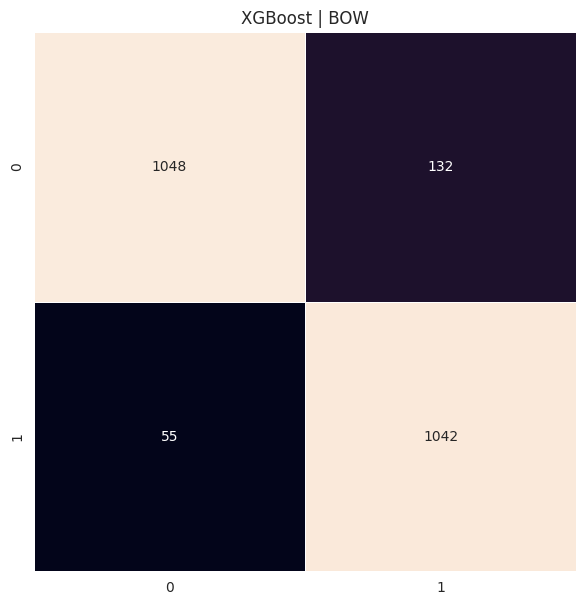

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("XGBoost | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# XGB TF-İDF

In [33]:
import xgboost
xgb = xgboost.XGBClassifier()
xgb_model_tf = xgb.fit(x_train_tf_idf, y_train)
acc = model_selection.cross_val_score(
    xgb_model_tf,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("XGBoost | TF-IDF")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = xgb_model_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.9073484797411178 



              precision    recall  f1-score   support

           0     0.9500    0.8856    0.9167      1180
           1     0.8853    0.9499    0.9164      1097

    accuracy                         0.9166      2277
   macro avg     0.9177    0.9177    0.9166      2277
weighted avg     0.9188    0.9166    0.9166      2277



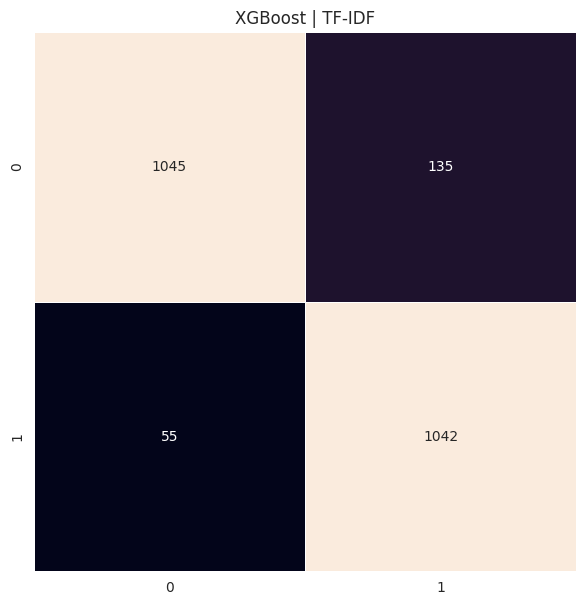

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("XGBoost | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# dT BOW

In [34]:
from sklearn.tree import DecisionTreeClassifier
maximum_tree_depth= 50
dt = DecisionTreeClassifier(max_depth=maximum_tree_depth)
model_dt_bow=dt.fit(x_train_count, y_train)
acc = model_selection.cross_val_score(
    model_dt_bow,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("Decision Tree | BOW")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = model_dt_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.8660662037349154 



              precision    recall  f1-score   support

           0     0.9159    0.8585    0.8863      1180
           1     0.8574    0.9152    0.8854      1097

    accuracy                         0.8858      2277
   macro avg     0.8867    0.8868    0.8858      2277
weighted avg     0.8877    0.8858    0.8858      2277



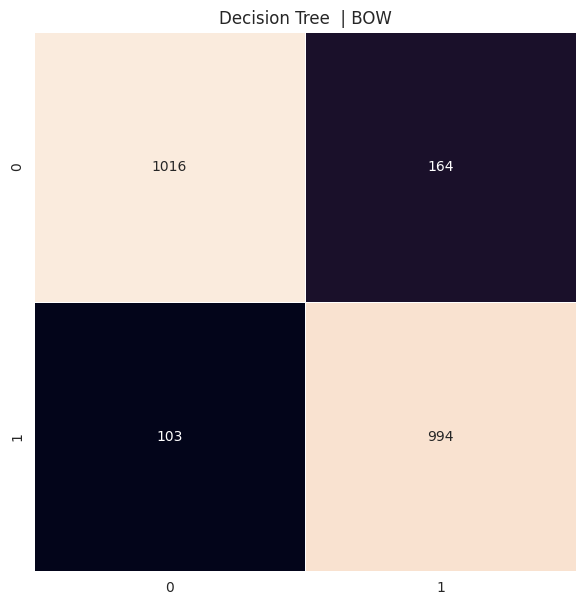

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("Decision Tree  | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# dT TF-İDF

In [35]:
from sklearn.tree import DecisionTreeClassifier
maximum_tree_depth= 50
dt = DecisionTreeClassifier(max_depth=maximum_tree_depth)
model_dt_tf=dt.fit(x_train_tf_idf, y_train)
acc = model_selection.cross_val_score(
    model_dt_tf,
    x_test_count,
    y_test,
    cv=7).mean()


y_pred = model_dt_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9207    0.8661    0.8926      1180
           1     0.8646    0.9198    0.8913      1097

    accuracy                         0.8920      2277
   macro avg     0.8927    0.8929    0.8920      2277
weighted avg     0.8937    0.8920    0.8920      2277



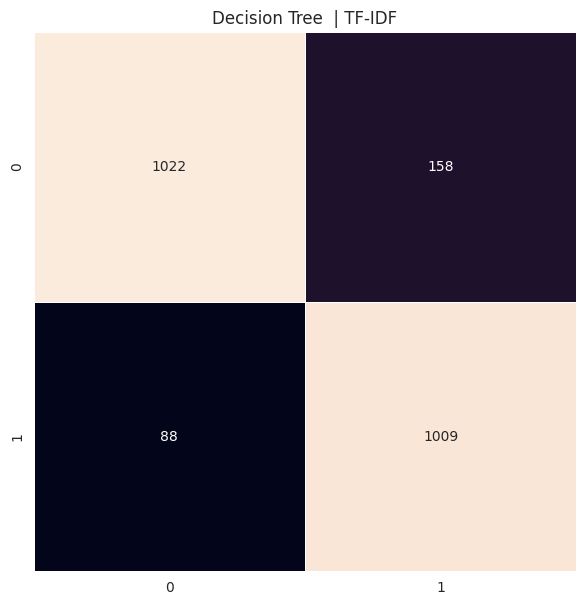

In [36]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("Decision Tree  | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# KNN_BOW

In [37]:
from sklearn.neighbors import KNeighborsClassifier
number_of_neigbors = 5
minkowski_power = 2 # Manhattan Distance = 1, Euclidean Distance = 2
knn = KNeighborsClassifier(n_neighbors=number_of_neigbors, p =minkowski_power)
model_knn_bow=knn.fit(x_train_count, y_train)
acc = model_selection.cross_val_score(
    model_knn_bow,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("Decision Tree | Count Vectorizer")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = model_knn_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.7861093507719276 



              precision    recall  f1-score   support

           0     0.8008    0.8856    0.8410      1180
           1     0.8611    0.7630    0.8091      1097

    accuracy                         0.8265      2277
   macro avg     0.8309    0.8243    0.8251      2277
weighted avg     0.8298    0.8265    0.8256      2277



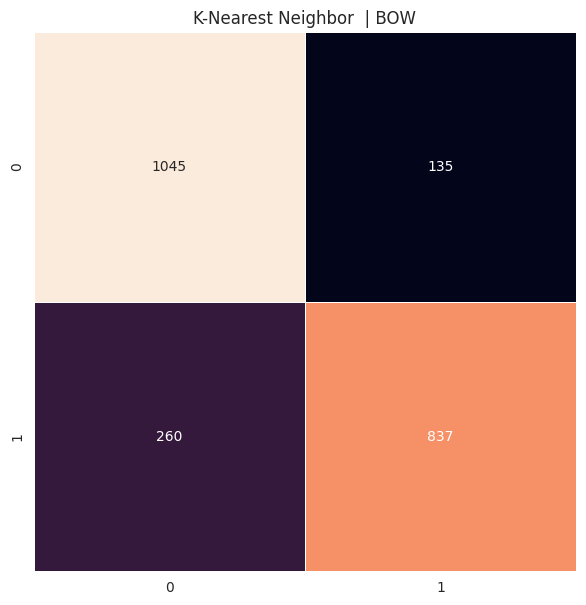

In [38]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("K-Nearest Neighbor  | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# KNN TF-İDF

In [39]:
from sklearn.neighbors import KNeighborsClassifier
number_of_neigbors = 5
minkowski_power = 2 # Manhattan Distance = 1, Euclidean Distance = 2
knn = KNeighborsClassifier(n_neighbors=number_of_neigbors, p =minkowski_power)
model_knn_tf=knn.fit(x_train_tf_idf, y_train)
acc = model_selection.cross_val_score(
    model_knn_tf,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("Decision Tree | TF-IDF")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = model_knn_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.7861093507719276 



              precision    recall  f1-score   support

           0     0.6010    0.9254    0.7287      1180
           1     0.8087    0.3391    0.4778      1097

    accuracy                         0.6430      2277
   macro avg     0.7048    0.6323    0.6033      2277
weighted avg     0.7011    0.6430    0.6079      2277



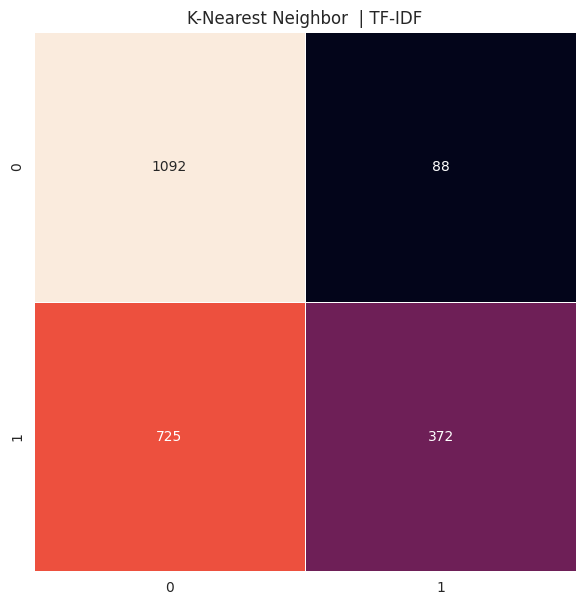

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("K-Nearest Neighbor  | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# SVM_bow

In [41]:
from sklearn.svm import LinearSVC
l2_norm = 2
l2_norm_inverse = 1/l2_norm
maximum_iterations=4000 #maximum number of iterations
svm = LinearSVC(C=l2_norm_inverse,max_iter=maximum_iterations) #create support vector machine model

model_svm_bow=svm.fit(x_train_count, y_train)
acc = model_selection.cross_val_score(
    model_svm_bow,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("Support Vector Machine | Count Vectorizer")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = model_svm_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.9069089193015574 



              precision    recall  f1-score   support

           0     0.9190    0.9034    0.9111      1180
           1     0.8979    0.9143    0.9061      1097

    accuracy                         0.9087      2277
   macro avg     0.9085    0.9089    0.9086      2277
weighted avg     0.9088    0.9087    0.9087      2277



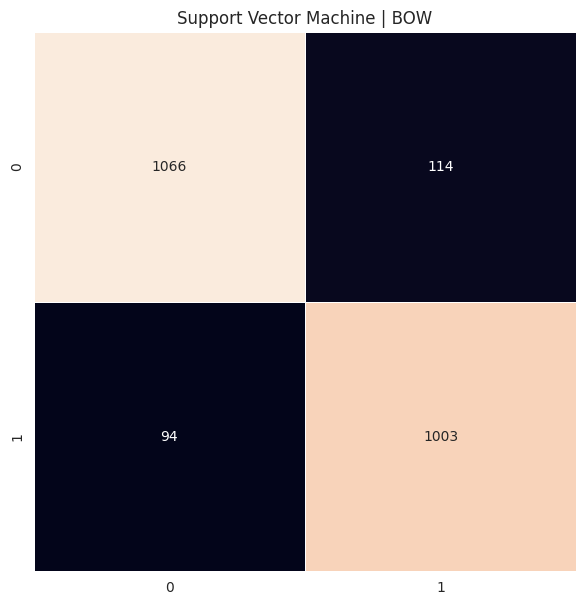

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("Support Vector Machine | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

In [43]:
from sklearn.svm import LinearSVC
l2_norm = 2
l2_norm_inverse = 1/l2_norm
maximum_iterations=4000 #maximum number of iterations
svm = LinearSVC(C=l2_norm_inverse,max_iter=maximum_iterations) #create support vector machine model

model_svm_tf=svm.fit(x_train_tf_idf, y_train)
acc = model_selection.cross_val_score(
    model_svm_tf,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("Support Vector Machine | TF-IDF")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = model_svm_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.9069089193015574 



              precision    recall  f1-score   support

           0     0.8933    0.9085    0.9008      1180
           1     0.8997    0.8833    0.8914      1097

    accuracy                         0.8964      2277
   macro avg     0.8965    0.8959    0.8961      2277
weighted avg     0.8964    0.8964    0.8963      2277



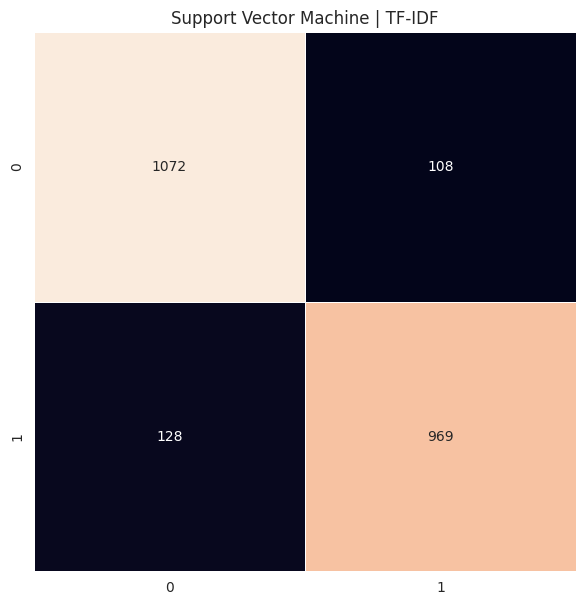

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("Support Vector Machine | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# Adaboost

In [45]:
from sklearn.ensemble import AdaBoostClassifier
model_boosted_dt = AdaBoostClassifier(n_estimators=10, random_state=0)

model_boosted_dt_bow=model_boosted_dt.fit(x_train_count, y_train)
acc = model_selection.cross_val_score(
    model_boosted_dt_bow,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("AdaBoost | Count Vectorizer")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = model_boosted_dt_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.834876289354817 



              precision    recall  f1-score   support

           0     0.9182    0.7424    0.8210      1180
           1     0.7702    0.9289    0.8421      1097

    accuracy                         0.8322      2277
   macro avg     0.8442    0.8356    0.8316      2277
weighted avg     0.8469    0.8322    0.8312      2277



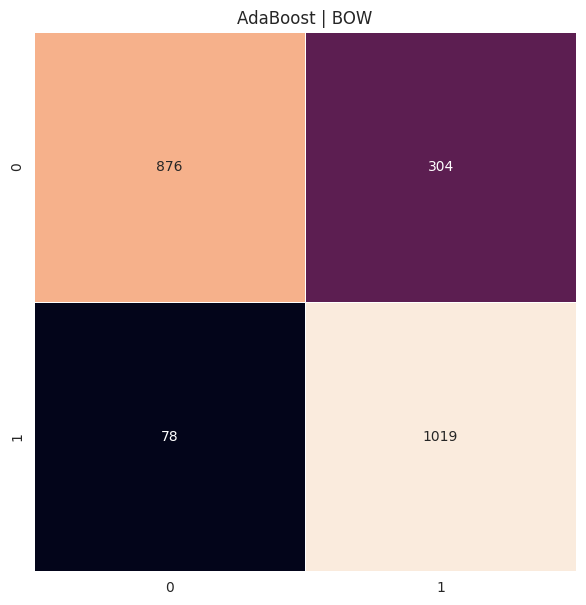

In [46]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("AdaBoost | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

In [47]:
from sklearn.ensemble import AdaBoostClassifier
model_boosted_dt = AdaBoostClassifier(n_estimators=10, random_state=0)

model_boosted_dt_tf=model_boosted_dt.fit(x_train_tf_idf, y_train)
acc = model_selection.cross_val_score(
    model_boosted_dt_tf,
    x_test_count,
    y_test,
    cv=7).mean()

model_names.append("AdaBoost  | TF-IDF")
models_results.append(acc)
print("Accuracy Count:", acc, "\n\n\n")

y_pred = model_boosted_dt_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,digits=4))

Accuracy Count: 0.834876289354817 



              precision    recall  f1-score   support

           0     0.9182    0.7424    0.8210      1180
           1     0.7702    0.9289    0.8421      1097

    accuracy                         0.8322      2277
   macro avg     0.8442    0.8356    0.8316      2277
weighted avg     0.8469    0.8322    0.8312      2277



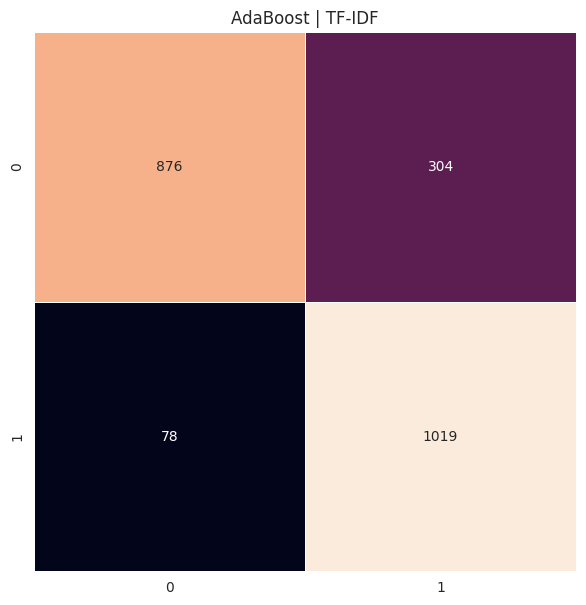

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
plt.title("AdaBoost | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# Stacking bow

In [49]:
estimators = [

    ("log",log_model_bow),
    ("nb",nb_model_bow),
    ("xgb",xgb_model_bow),
    ("dt",model_dt_bow),
    ("knn",model_knn_bow),
    ("svm",model_svm_bow),
    ("adaboost",model_boosted_dt_bow)


]

from sklearn.ensemble import StackingClassifier
model_stacked_bow = StackingClassifier(estimators=estimators)
model_stacked_bow.fit(x_train_count, y_train)

acc = model_selection.cross_val_score(
    model_stacked_bow,
    x_test_count,
    y_test,
    cv=7).mean()
model_names.append("Stacking  | BOW")

models_results.append(acc)

print("Accuracy Count:", acc, "\n\n\n")

y_pred_stacked = model_stacked_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_stacked,digits=4))

Accuracy Count: 0.9205218094788646 



              precision    recall  f1-score   support

           0     0.9444    0.9076    0.9257      1180
           1     0.9046    0.9426    0.9232      1097

    accuracy                         0.9245      2277
   macro avg     0.9245    0.9251    0.9244      2277
weighted avg     0.9253    0.9245    0.9245      2277



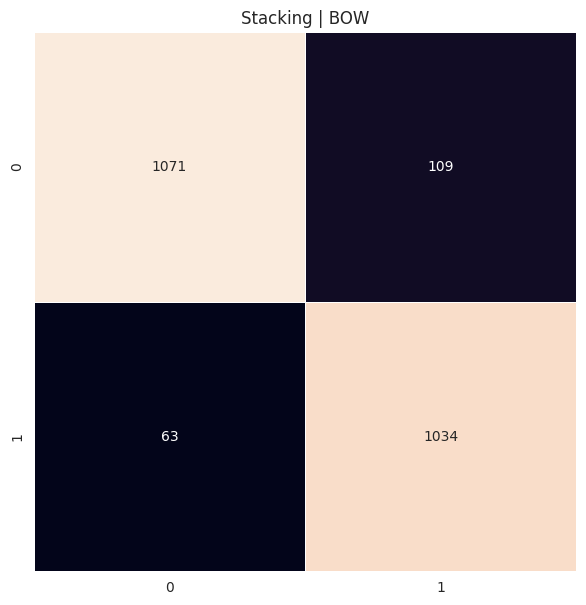

In [50]:
cm = confusion_matrix(y_test, y_pred_stacked)
plt.figure(figsize=(7,7))
plt.title("Stacking | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# Stacking tf-idf

In [51]:
estimators = [

    ("log",log_model_tf),
    ("nb",nb_model_tf),
    ("xgb",xgb_model_tf),
    ("dt",model_dt_tf),
    ("knn",model_knn_tf),
    ("svm",model_svm_tf),
    ("adaboost",model_boosted_dt_tf)


]

from sklearn.ensemble import StackingClassifier
model_stacked_tf = StackingClassifier(estimators=estimators)
model_stacked_tf.fit(x_train_tf_idf, y_train)

acc = model_selection.cross_val_score(
    model_stacked_tf,
    x_test_count,
    y_test,
    cv=7).mean()
model_names.append("Stacking  | TF-IDF")

models_results.append(acc)

print("Accuracy Count:", acc, "\n\n\n")


y_pred_stacked = model_stacked_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_stacked,digits=4))

Accuracy Count: 0.9214009303579856 



              precision    recall  f1-score   support

           0     0.9374    0.9136    0.9253      1180
           1     0.9095    0.9344    0.9218      1097

    accuracy                         0.9236      2277
   macro avg     0.9234    0.9240    0.9235      2277
weighted avg     0.9240    0.9236    0.9236      2277



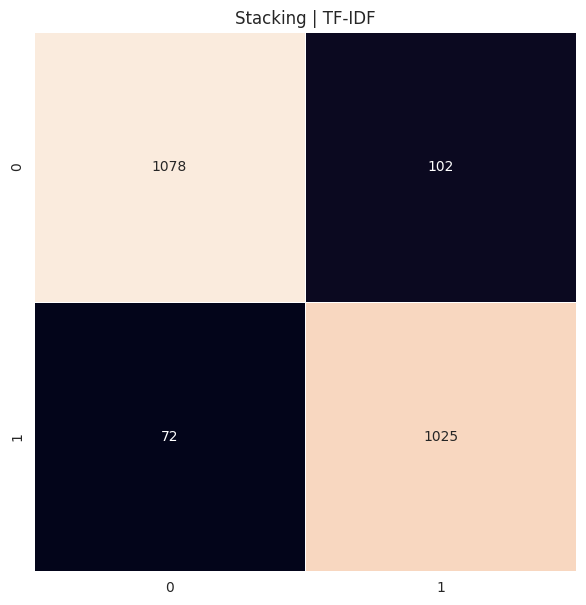

In [52]:
cm = confusion_matrix(y_test, y_pred_stacked)
plt.figure(figsize=(7,7))
plt.title("Stacking | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# hard voting

In [53]:

estimators = [

    ("log",log_model_bow),
    ("nb",nb_model_bow),
    ("xgb",xgb_model_bow),
    ("dt",model_dt_bow),
    ("knn",model_knn_bow),
    ("svm",model_svm_bow),
    ("adaboost",model_boosted_dt_bow)



]

from sklearn.ensemble import VotingClassifier
model_voting_bow = VotingClassifier(estimators=estimators, voting='hard')
model_voting_bow.fit(x_train_count, y_train)


acc = model_selection.cross_val_score(
    model_voting_bow,
    x_test_count,
    y_test,
    cv=7).mean()
model_names.append("Hard Voting  | BOW")

models_results.append(acc)

print("Accuracy Count:", acc, "\n\n\n")



y_pred_voting = model_voting_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_voting,digits=4))

Accuracy Count: 0.9148129171442055 



              precision    recall  f1-score   support

           0     0.9477    0.8898    0.9178      1180
           1     0.8888    0.9471    0.9170      1097

    accuracy                         0.9174      2277
   macro avg     0.9182    0.9185    0.9174      2277
weighted avg     0.9193    0.9174    0.9174      2277



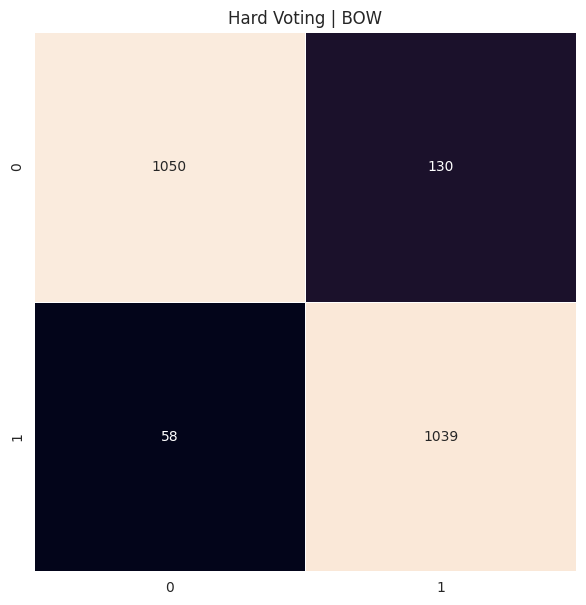

In [54]:
cm = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(7,7))
plt.title("Hard Voting | BOW")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# soft voting

In [55]:

estimators = [

    ("log",log_model_bow),
    ("nb",nb_model_bow),
    ("xgb",xgb_model_bow),
    ("dt",model_dt_bow),
    ("knn",model_knn_bow),
    ("adaboost",model_boosted_dt_bow)



]

from sklearn.ensemble import VotingClassifier
model_voting_bow = VotingClassifier(estimators=estimators, voting='soft')
model_voting_bow.fit(x_train_count, y_train)


acc = model_selection.cross_val_score(
    model_voting_bow,
    x_test_count,
    y_test,
    cv=7).mean()
model_names.append("Soft Voting  | BOW")

models_results.append(acc)

print("Accuracy Count:", acc, "\n\n\n")




y_pred_voting = model_voting_bow.predict(x_test_count)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_voting,digits=4))

Accuracy Count: 0.9130533270410571 



              precision    recall  f1-score   support

           0     0.9505    0.8941    0.9214      1180
           1     0.8929    0.9499    0.9205      1097

    accuracy                         0.9209      2277
   macro avg     0.9217    0.9220    0.9209      2277
weighted avg     0.9227    0.9209    0.9210      2277



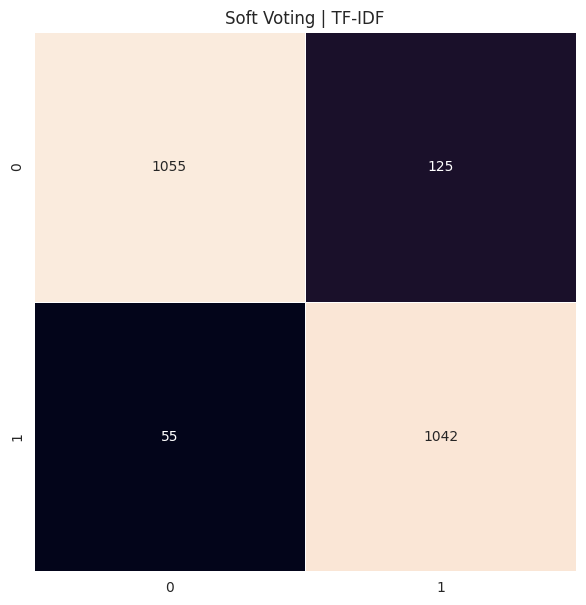

In [56]:
cm = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(7,7))
plt.title("Soft Voting | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# hard voting

In [57]:
estimators = [

    ("log",log_model_tf),
    ("nb",nb_model_tf),
    ("xgb",xgb_model_tf),
    ("dt",model_dt_tf),
    ("knn",model_knn_tf),
    ("svm",model_svm_tf),
    ("adaboost",model_boosted_dt_tf)


]

from sklearn.ensemble import VotingClassifier
model_voting_tf = VotingClassifier(estimators=estimators,voting='hard')
model_voting_tf.fit(x_train_tf_idf, y_train)

acc = model_selection.cross_val_score(
    model_voting_tf,
    x_test_count,
    y_test,
    cv=7).mean()
model_names.append("Hard Voting  | TF-IDF")

models_results.append(acc)

print("Accuracy Count:", acc, "\n\n\n")


y_pred_voting = model_voting_tf.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_voting,digits=4))

Accuracy Count: 0.9152511292388593 



              precision    recall  f1-score   support

           0     0.9196    0.9203    0.9199      1180
           1     0.9142    0.9134    0.9138      1097

    accuracy                         0.9170      2277
   macro avg     0.9169    0.9169    0.9169      2277
weighted avg     0.9170    0.9170    0.9170      2277



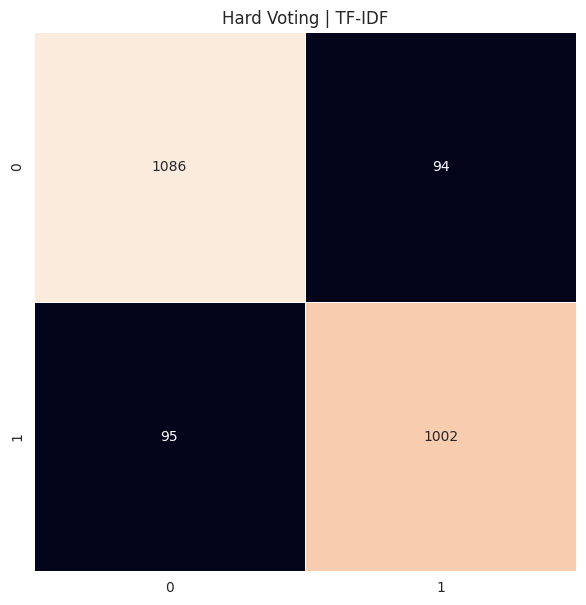

In [58]:
cm = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(7,7))
plt.title("Hard Voting | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

# soft voting

In [59]:
estimators = [

    ("log",log_model_tf),
    ("nb",nb_model_tf),
    ("xgb",xgb_model_tf),
    ("dt",model_dt_tf),
    ("knn",model_knn_tf),
    ("adaboost",model_boosted_dt_tf)


]

from sklearn.ensemble import VotingClassifier
model_voting_TF = VotingClassifier(estimators=estimators,voting='soft')
model_voting_TF.fit(x_train_tf_idf, y_train)



acc = model_selection.cross_val_score(
    model_voting_TF,
    x_test_count,
    y_test,
    cv=7).mean()
model_names.append("Soft Voting  | TF-IDF")

models_results.append(acc)

print("Accuracy Count:", acc, "\n\n\n")



y_pred_voting = model_voting_TF.predict(x_test_tf_idf)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_voting,digits=4))

Accuracy Count: 0.9143679633250185 



              precision    recall  f1-score   support

           0     0.9341    0.9127    0.9233      1180
           1     0.9084    0.9307    0.9194      1097

    accuracy                         0.9214      2277
   macro avg     0.9212    0.9217    0.9213      2277
weighted avg     0.9217    0.9214    0.9214      2277



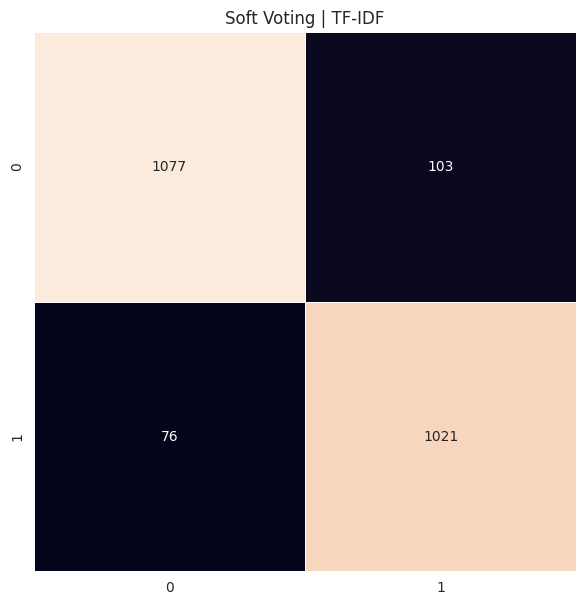

In [60]:
cm = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(7,7))
plt.title("Soft Voting | TF-IDF")
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False)
plt.show()

#gridsearch


In [62]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters grid for each model
param_grid_logistic = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
param_grid_xgb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5]}
param_grid_dt = {'max_depth': [5, 10, 20]}
param_grid_knn = {'n_neighbors': [3, 5, 7]}
param_grid_svm = {'C': [0.1, 1, 10]} #'kernel': ['linear', 'rbf']

param_grids = {
    'Logistic Regression | BOW': (log_model_bow, param_grid_logistic),
    'Logistic Regression | TF-IDF': (log_model_tf, param_grid_logistic),
    'XGBoost | BOW': (xgb_model_bow, param_grid_xgb),
    'XGBoost | TF-IDF': (xgb_model_tf, param_grid_xgb),
    'Decision Tree | BOW': (model_dt_bow, param_grid_dt),
    'Decision Tree | TF-IDF': (model_dt_tf, param_grid_dt),
    'K-Nearest Neighbor | BOW': (model_knn_bow, param_grid_knn),
    'K-Nearest Neighbor | TF-IDF': (model_knn_tf, param_grid_knn),
    'Support Vector Machine | BOW': (model_svm_bow, param_grid_svm),
    'Support Vector Machine | TF-IDF': (model_svm_tf, param_grid_svm),
}

# Perform grid search with cross-validation for each model
for model_name, (model, param_grid) in param_grids.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train_count, y_train)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}\n")



Best parameters for Logistic Regression | BOW: {'C': 1, 'penalty': 'l2'}
Best cross-validation accuracy: 0.9183

Best parameters for Logistic Regression | TF-IDF: {'C': 1, 'penalty': 'l2'}
Best cross-validation accuracy: 0.9183

Best parameters for XGBoost | BOW: {'max_depth': 4, 'n_estimators': 200}
Best cross-validation accuracy: 0.9202

Best parameters for XGBoost | TF-IDF: {'max_depth': 4, 'n_estimators': 200}
Best cross-validation accuracy: 0.9202

Best parameters for Decision Tree | BOW: {'max_depth': 20}
Best cross-validation accuracy: 0.8995

Best parameters for Decision Tree | TF-IDF: {'max_depth': 20}
Best cross-validation accuracy: 0.9002

Best parameters for K-Nearest Neighbor | BOW: {'n_neighbors': 7}
Best cross-validation accuracy: 0.8258

Best parameters for K-Nearest Neighbor | TF-IDF: {'n_neighbors': 7}
Best cross-validation accuracy: 0.8258

Best parameters for Support Vector Machine | BOW: {'C': 0.1}
Best cross-validation accuracy: 0.9172

Best parameters for Support